# Capstone Project - Avoiding accidents and Predicting accident severity

## IMPORT section

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

## Get Collision data csv file and put it into a dataframe

In [2]:
raw_df = pd.read_csv(r"C:\Temp\Data-Collisions.csv")
raw_df.head()

C:\Users\kpurs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## ANALYSE the raw collision data

In [5]:
#Get the row/column count
raw_df.shape

(194673, 38)

In [6]:
#Get a decription of the raw data
raw_df.describe

<bound method NDFrame.describe of         SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY  \
0                  2 -122.323148  47.703140         1    1307       1307   
1                  1 -122.347294  47.647172         2   52200      52200   
2                  1 -122.334540  47.607871         3   26700      26700   
3                  1 -122.334803  47.604803         4    1144       1144   
4                  2 -122.306426  47.545739         5   17700      17700   
...              ...         ...        ...       ...     ...        ...   
194668             2 -122.290826  47.565408    219543  309534     310814   
194669             1 -122.344526  47.690924    219544  309085     310365   
194670             2 -122.306689  47.683047    219545  311280     312640   
194671             2 -122.355317  47.678734    219546  309514     310794   
194672             1 -122.289360  47.611017    219547  308220     309500   

       REPORTNO   STATUS      ADDRTYPE   INTKEY  ... 

In [56]:
raw_df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [57]:
raw_df['STATUS'].value_counts()

Matched      189786
Unmatched      4887
Name: STATUS, dtype: int64

In [58]:
raw_df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [59]:
raw_df['ROADCOND'].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [60]:
raw_df['LIGHTCOND'].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [61]:
raw_df['COLLISIONTYPE'].value_counts()

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

In [62]:
raw_df['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

In [63]:
raw_df['VEHCOUNT'].value_counts()

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

In [7]:
#Get some possible data groups to have a look at severity codes
raw_df.groupby(['COLLISIONTYPE','WEATHER','ROADCOND','LIGHTCOND'])['SEVERITYCODE'].value_counts()  #value_counts(normalize=True)

COLLISIONTYPE  WEATHER            ROADCOND  LIGHTCOND                SEVERITYCODE
Angles         Blowing Sand/Dirt  Dry       Dark - Street Lights On  2                1
                                            Daylight                 2                1
                                  Wet       Dark - Street Lights On  2                1
                                            Daylight                 1                2
                                                                     2                1
                                                                                     ..
Sideswipe      Unknown            Wet       Daylight                 1               11
                                                                     2                2
                                            Dusk                     1                2
                                                                     2                1
                                      

## FEATURE selection.

In [8]:
#get the features that can be used for map plots and predicting severity
feature_df = raw_df[['SEVERITYCODE','X','Y','VEHCOUNT','COLLISIONTYPE','WEATHER','ROADCOND','LIGHTCOND','INCDTTM']]
feature_df.tail()

,SEVERITYCODE,X,Y,VEHCOUNT,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,INCDTTM
194668,2,-122.290826,47.565408,2,Head On,Clear,Dry,Daylight,11/12/2018 8:12:00 AM
194669,1,-122.344526,47.690924,2,Rear Ended,Raining,Wet,Daylight,12/18/2018 9:14:00 AM
194670,2,-122.306689,47.683047,2,Left Turn,Clear,Dry,Daylight,1/19/2019 9:25:00 AM
194671,2,-122.355317,47.678734,1,Cycles,Clear,Dry,Dusk,1/15/2019 4:48:00 PM
194672,1,-122.289360,47.611017,2,Rear Ended,Clear,Wet,Daylight,11/30/2018 3:45:00 PM


In [9]:
#confirm df size
feature_df.shape

(194673, 9)

## CLEAN the data

In [67]:
#DROP rows with missing values
feature_df = feature_df.dropna()

#DROP rows that do not include vehicles
feature_df = feature_df[feature_df['VEHCOUNT']>0]

#CONVERT INCDTTM to datetime in order to access Date and Time components
feature_df['INCDTTM'] = pd.to_datetime(feature_df['INCDTTM'])

print(feature_df.shape)
feature_df.head()

(183950, 9)


,SEVERITYCODE,X,Y,VEHCOUNT,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,INCDTTM
0,2,-122.323148,47.703140,2,Angles,Overcast,Wet,Daylight,2013-03-27 14:54:00
1,1,-122.347294,47.647172,2,Sideswipe,Raining,Wet,Dark - Street Lights On,2006-12-20 18:55:00
2,1,-122.334540,47.607871,3,Parked Car,Overcast,Dry,Daylight,2004-11-18 10:20:00
3,1,-122.334803,47.604803,3,Other,Clear,Dry,Daylight,2013-03-29 09:26:00
4,2,-122.306426,47.545739,2,Angles,Raining,Wet,Daylight,2004-01-28 08:04:00


In [68]:
# count the number of missing values per column to determine if additional cleaning is required
feature_df.apply(lambda x: sum(x.isnull().values), axis = 0)

SEVERITYCODE     0
X                0
Y                0
VEHCOUNT         0
COLLISIONTYPE    0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
INCDTTM          0
dtype: int64

In [69]:
# count the number of rows that are missing at least 1 of the values
sum([True for idx,row in feature_df.iterrows() if any(row.isnull())])

0

In [70]:
#dataframe data types
feature_df.dtypes

SEVERITYCODE              int64
X                       float64
Y                       float64
VEHCOUNT                  int64
COLLISIONTYPE            object
WEATHER                  object
ROADCOND                 object
LIGHTCOND                object
INCDTTM          datetime64[ns]
dtype: object

## ANALYZE the feature set (feature_df)

In [71]:
#Date range within dataframe
print('min',feature_df['INCDTTM'].min())
print('max',feature_df['INCDTTM'].max())

min 2004-01-01 00:00:00
max 2020-04-28 11:29:00


In [72]:
#accident count by year. 
#Trend is toward few accidents after 2015
feature_df.groupby([feature_df.INCDTTM.dt.year]).size()

INCDTTM
2004    11560
2005    14753
2006    14800
2007    14017
2008    13154
2009    11296
2010    10512
2011    10588
2012     9996
2013     9734
2014    11166
2015    12157
2016    10558
2017    10146
2018     9652
2019     8618
2020     1243
dtype: int64

In [73]:
#accident count by HOUR
feature_df.groupby([feature_df.INCDTTM.dt.hour]).size()

INCDTTM
0     28573
1      3294
2      3457
3      1593
4      1175
5      1584
6      3078
7      6337
8      8257
9      7786
10     7213
11     7965
12    10046
13     9972
14    10361
15    11199
16    11793
17    12579
18     9462
19     7053
20     6037
21     5411
22     5296
23     4429
dtype: int64

In [74]:
feature_df['SEVERITYCODE'].value_counts()

1    128143
2     55807
Name: SEVERITYCODE, dtype: int64

In [75]:
feature_df['VEHCOUNT'].value_counts()

2     143682
1      24455
3      12699
4       2377
5        520
6        143
7         42
8         15
9          9
11         5
10         2
12         1
Name: VEHCOUNT, dtype: int64

In [76]:
feature_df['WEATHER'].value_counts()

Clear                       108681
Raining                      31962
Overcast                     27071
Unknown                      13841
Snowing                        888
Other                          764
Fog/Smog/Smoke                 553
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               49
Severe Crosswind                24
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [77]:
feature_df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts()

SEVERITYCODE  WEATHER                 
1             Clear                       73557
              Raining                     21130
              Overcast                    18500
              Unknown                     13070
              Snowing                       722
              Other                         655
              Fog/Smog/Smoke                369
              Sleet/Hail/Freezing Rain       85
              Blowing Sand/Dirt              36
              Severe Crosswind               17
              Partly Cloudy                   2
2             Clear                       35124
              Raining                     10832
              Overcast                     8571
              Unknown                       771
              Fog/Smog/Smoke                184
              Snowing                       166
              Other                         109
              Sleet/Hail/Freezing Rain       27
              Blowing Sand/Dirt              13
 

In [78]:
feature_df['ROADCOND'].value_counts()

Dry               121706
Wet                45971
Unknown            13788
Ice                 1168
Snow/Slush           984
Other                115
Standing Water       102
Sand/Mud/Dirt         63
Oil                   53
Name: ROADCOND, dtype: int64

In [79]:
feature_df.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts()

SEVERITYCODE  ROADCOND      
1             Dry               82464
              Wet               30645
              Unknown           13080
              Ice                 908
              Snow/Slush          819
              Other                77
              Standing Water       76
              Sand/Mud/Dirt        41
              Oil                  33
2             Dry               39242
              Wet               15326
              Unknown             708
              Ice                 260
              Snow/Slush          165
              Other                38
              Standing Water       26
              Sand/Mud/Dirt        22
              Oil                  20
Name: ROADCOND, dtype: int64

In [80]:
feature_df['LIGHTCOND'].value_counts()

Daylight                    113351
Dark - Street Lights On      47220
Unknown                      12413
Dusk                          5757
Dawn                          2417
Dark - No Street Lights       1448
Dark - Street Lights Off      1145
Other                          188
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [81]:
feature_df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts()

SEVERITYCODE  LIGHTCOND               
1             Daylight                    75642
              Dark - Street Lights On     33081
              Unknown                     11831
              Dusk                         3851
              Dawn                         1611
              Dark - No Street Lights      1130
              Dark - Street Lights Off      839
              Other                         151
              Dark - Unknown Lighting         7
2             Daylight                    37709
              Dark - Street Lights On     14139
              Dusk                         1906
              Dawn                          806
              Unknown                       582
              Dark - No Street Lights       318
              Dark - Street Lights Off      306
              Other                          37
              Dark - Unknown Lighting         4
Name: LIGHTCOND, dtype: int64

## Reduce the working dataset to a subset for train\test\plot

In [82]:
#REDUCE the data set size to 2019/2020
feature_reduced_df = feature_df[~(feature_df['INCDTTM'] < '2019-01-01')]

#Confirm date range for new dataframe
print('min',feature_reduced_df['INCDTTM'].min())
print('max',feature_reduced_df['INCDTTM'].max())
print('shape',feature_reduced_df.shape)
feature_reduced_df.head()

min 2019-01-01 00:12:00
max 2020-04-28 11:29:00
shape (9861, 9)


,SEVERITYCODE,X,Y,VEHCOUNT,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,INCDTTM
5,1,-122.387598,47.690575,2,Angles,Clear,Dry,Daylight,2019-04-20 17:42:00
7,2,-122.320780,47.614076,1,Cycles,Clear,Dry,Daylight,2020-04-15 17:47:00
18,2,-122.328270,47.571420,3,Rear Ended,Clear,Dry,Daylight,2020-04-17 14:44:00
25,2,-122.312857,47.599218,1,Cycles,Clear,Dry,Daylight,2019-04-25 09:40:00
35,1,-122.318741,47.676567,2,Parked Car,Raining,Wet,Daylight,2019-04-27 13:26:00


## ANALYZE the reduced feature set (feature_reduced_df)

In [83]:
#accident count by year. 
feature_reduced_df.groupby([feature_reduced_df.INCDTTM.dt.year]).size()

INCDTTM
2019    8618
2020    1243
dtype: int64

In [84]:
feature_reduced_df['SEVERITYCODE'].value_counts()

1    6537
2    3324
Name: SEVERITYCODE, dtype: int64

In [88]:
feature_reduced_df.groupby(['SEVERITYCODE'])['COLLISIONTYPE'].value_counts()

SEVERITYCODE  COLLISIONTYPE
1             Parked Car       1815
              Angles           1253
              Rear Ended        985
              Sideswipe         969
              Other             814
              Left Turn         413
              Right Turn        114
              Pedestrian         68
              Head On            64
              Cycles             42
2             Angles            815
              Rear Ended        683
              Pedestrian        426
              Cycles            336
              Left Turn         336
              Other             289
              Sideswipe         192
              Parked Car        173
              Head On            48
              Right Turn         26
Name: COLLISIONTYPE, dtype: int64

In [89]:
feature_reduced_df.groupby(['SEVERITYCODE'])['WEATHER'].value_counts()

SEVERITYCODE  WEATHER                 
1             Clear                       4166
              Raining                     1016
              Overcast                     994
              Unknown                      215
              Snowing                       79
              Other                         40
              Blowing Sand/Dirt             11
              Fog/Smog/Smoke                 9
              Sleet/Hail/Freezing Rain       4
              Partly Cloudy                  2
              Severe Crosswind               1
2             Clear                       2221
              Raining                      543
              Overcast                     504
              Snowing                       17
              Unknown                       16
              Other                         12
              Fog/Smog/Smoke                 4
              Partly Cloudy                  3
              Sleet/Hail/Freezing Rain       2
              Blowing

In [90]:
feature_reduced_df.groupby(['SEVERITYCODE'])['ROADCOND'].value_counts()

SEVERITYCODE  ROADCOND      
1             Dry               4541
              Wet               1593
              Unknown            247
              Snow/Slush          74
              Ice                 67
              Other                7
              Oil                  4
              Standing Water       4
2             Dry               2403
              Wet                842
              Unknown             38
              Ice                 20
              Snow/Slush          14
              Other                6
              Sand/Mud/Dirt        1
Name: ROADCOND, dtype: int64

In [91]:
feature_reduced_df.groupby(['SEVERITYCODE'])['LIGHTCOND'].value_counts()

SEVERITYCODE  LIGHTCOND               
1             Daylight                    4179
              Dark - Street Lights On     1724
              Unknown                      219
              Dusk                         187
              Dawn                         104
              Dark - No Street Lights       67
              Dark - Street Lights Off      40
              Other                         10
              Dark - Unknown Lighting        7
2             Daylight                    2255
              Dark - Street Lights On      840
              Dusk                         123
              Dawn                          52
              Dark - No Street Lights       19
              Unknown                       15
              Dark - Street Lights Off      10
              Other                          6
              Dark - Unknown Lighting        4
Name: LIGHTCOND, dtype: int64

## Show accidents on City MAP

In [92]:
#choose accidents within the last <timeframe - TBD> to show on a map. The map can be redrawn based on an interval i.e. 15/30/60 minutes.
map_accident = feature_reduced_df[~(feature_reduced_df['INCDTTM'] < '2020-04-25')]
print('shape',map_accident.shape)
map_accident.head()

shape (6, 9)


,SEVERITYCODE,X,Y,VEHCOUNT,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,INCDTTM
143,1,-122.379426,47.675993,2,Parked Car,Overcast,Wet,Dark - Street Lights On,2020-04-25 23:00:00
392,1,-122.344977,47.723212,2,Angles,Raining,Wet,Daylight,2020-04-25 08:29:00
551,1,-122.274106,47.667500,1,Other,Clear,Dry,Dawn,2020-04-27 05:28:00
562,2,-122.321877,47.605770,2,Left Turn,Overcast,Dry,Daylight,2020-04-26 15:20:00
192160,1,-122.343624,47.617528,2,Angles,Clear,Dry,Daylight,2020-04-27 13:38:00


## Use folium for mapping

In [93]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\kpurs\anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.5                |   py38h9bdc248_3         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                                4.8.5-py38h9bdc248_2 --> 4.8.5-py38h9bdc248_3




conda-4.8.5          | 3.1 MB    |            |   0% 
conda-4.8.5          | 3.1 MB    |            |   1% 
conda-4.8.5          | 3.1 MB    | 8          |   9% 
conda-4.8.5          | 3.1 MB    | ##         |  20% 
conda-4.8.5          | 3.1 MB    | #####3     |  53% 
conda-4.8.5          | 3.1 MB    | #######2   |  72% 
conda-4.8.5          | 3.1 MB    | #

In [94]:
seattle_map = folium.Map(location=[47.6000, -122.3100], zoom_start=12)
for index, row in map_accident.iterrows():
    folium.Marker(
        location=[row['Y'],row['X']],
        
        #popup includes how many vehicles involved and date(M-D) time(HH-MM)
        popup= str(row['VEHCOUNT']) + ' vehicle collision reported ' + str(row['INCDTTM'].month) + '-' + str(row['INCDTTM'].day) +' at ' + str(row['INCDTTM'].hour) + ":" + str(row['INCDTTM'].minute),
        
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_to(seattle_map)
    
seattle_map

## Use One Hot Encoding technique to convert categorical variables

In [95]:
#unchanged columns
Feature = feature_reduced_df[['VEHCOUNT']]

#encode categorical values and append to dataframe
Feature = pd.concat([Feature,pd.get_dummies(feature_reduced_df['COLLISIONTYPE'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(feature_reduced_df['WEATHER'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(feature_reduced_df['ROADCOND'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(feature_reduced_df['LIGHTCOND'])], axis=1)

Feature.head()

,VEHCOUNT,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,...,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,Unknown
5,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
25,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35,2,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [96]:
Feature.shape

(9861, 40)

In [97]:
X = Feature
X[0:5]

,VEHCOUNT,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,...,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,Unknown
5,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
25,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
35,2,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [98]:
y = feature_reduced_df['SEVERITYCODE'].values
y[0:5]

array([1, 2, 2, 2, 1], dtype=int64)

## Normaize Data

In [99]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.07538525,  1.94123034, -0.19965171, -0.10718376, -0.2867042 ,
        -0.35488307, -0.50250231, -0.22964829, -0.45120774, -0.12000754,
        -0.36530573, -0.03490556,  0.73750751, -0.0363327 , -0.07280971,
        -0.42322845, -0.02252344, -0.43334291, -0.0142429 , -0.02467444,
        -0.09915155, -0.15487911,  0.64813184, -0.09434599, -0.02014455,
        -0.0363327 , -0.01007074, -0.09489152, -0.02014455, -0.17251639,
        -0.57262725, -0.09379741, -0.07138852, -0.59277085, -0.03341783,
        -0.12678402,  0.72982128, -0.18015919, -0.04031365, -0.15590586],
       [-1.60645625, -0.51513722,  5.00872255, -0.10718376, -0.2867042 ,
        -0.35488307, -0.50250231, -0.22964829, -0.45120774, -0.12000754,
        -0.36530573, -0.03490556,  0.73750751, -0.0363327 , -0.07280971,
        -0.42322845, -0.02252344, -0.43334291, -0.0142429 , -0.02467444,
        -0.09915155, -0.15487911,  0.64813184, -0.09434599, -0.02014455,
        -0.0363327 , -0.01007074, -0.09489152, -0.

## Setup TRAIN TEST split

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
#Create the TRAIN (80%) TEST(20%) split. X is the feature set. y is the labels for loan status

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (7888, 40) (7888,)
Test set: (1973, 40) (1973,)


## Model Accuracy imports

In [102]:
from sklearn import metrics
from sklearn.metrics import f1_score
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

## KNN Model

In [103]:
#Get the imports
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt

In [104]:
#try a range of k values to find best accuracy.

Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    
    #accuracy formula
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    #calculate std
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.66041561, 0.71160669, 0.67714141, 0.70400405, 0.70349721,
       0.72883933, 0.7212367 , 0.73188039, 0.70248353, 0.70552458,
       0.700963  , 0.70299037, 0.69994932, 0.70299037, 0.70146984,
       0.72326406, 0.72630512, 0.7273188 , 0.72630512])

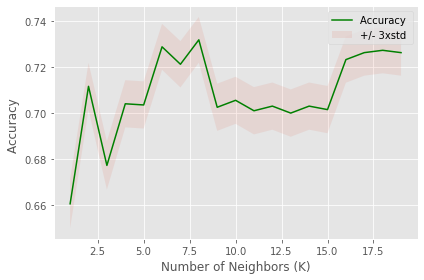

In [105]:
#Plot the k vs accuracy from previous step
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [106]:
#Jaccard score
print( "KNN Model best accuracy score is", mean_acc.max(), " when k =", mean_acc.argmax()+1) 

#F1-score
y_pred = neigh.predict(X_test)
print("KNN model F1-score is", f1_score(y_test, y_pred, average='weighted'))

KNN Model best accuracy score is 0.7318803852002027  when k = 8
KNN model F1-score is 0.7008743808776231


## Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier

In [108]:
accident_DT = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
accident_DT.fit(X_train,y_train)
accident_DT_yhat = accident_DT.predict(X_test)

In [109]:
#accuracy
print("Decision Tree accuracy is ", metrics.accuracy_score(y_test, accident_DT_yhat))

#F1-score
print("Decision Tree F1-score is", f1_score(y_test, accident_DT_yhat, average='weighted'))

Decision Tree accuracy is  0.7313735428281805
Decision Tree F1-score is 0.6760143772584613


## Support Vector Machine

In [110]:
from sklearn import svm

In [111]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
SVM_yhat = clf.predict(X_test)

In [112]:
#Accuracy
print("The SVM accuracy is",metrics.accuracy_score(y_test, SVM_yhat))

#F1-score
print("The SVM F1-score is", f1_score(y_test, SVM_yhat, average='weighted'))

The SVM accuracy is 0.7318803852002027
The SVM F1-score is 0.6872876689073995


## Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression

In [114]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [115]:
#calculate the needed yhat values
LR_yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

In [116]:
#Accuracy
print("The Logistic Regression accuracy is",metrics.accuracy_score(y_test, LR_yhat))

#F1-score
print("The Logistic Regression F1-score is", f1_score(y_test, LR_yhat, average='weighted'))

#Log loss
print ("Logistic Regression LogLoss is %.2f" % log_loss(y_test, yhat_prob))

The Logistic Regression accuracy is 0.7298530157121136
The Logistic Regression F1-score is 0.6804398074564196
Logistic Regression LogLoss is 0.52


## Plot Weather Trend

In [38]:
#setup imports
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print(plt.style.available)
mpl.style.use(['ggplot']) # optional: for ggplot-like style

Matplotlib version:  3.2.2
['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [39]:
#Common df to start

#setup a working df to start
work_df = feature_df

#add a year column based on INCDTTM
work_df.insert(0, 'Year', work_df['INCDTTM'].dt.year)

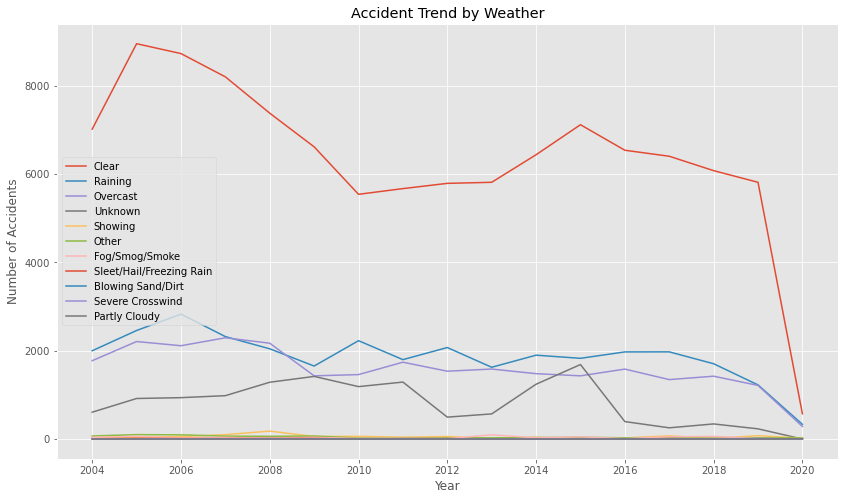

In [40]:
#PREPARE dataframe to plot

#Calculate totals for year-weather-combo
weather_df = work_df.groupby(['Year','WEATHER']).size().reset_index(name='Count')

#add the weather options as columns and move the groupby totals to corresponding column
weather_df['Clear'] = np.where(weather_df['WEATHER'].str.contains('Clear'),weather_df['Count'], 0)
weather_df['Raining'] = np.where(weather_df['WEATHER'].str.contains('Raining'),weather_df['Count'], 0)
weather_df['Overcast'] = np.where(weather_df['WEATHER'].str.contains('Overcast'),weather_df['Count'], 0)
weather_df['Unknown'] = np.where(weather_df['WEATHER'].str.contains('Unknown'),weather_df['Count'], 0)
weather_df['Showing'] = np.where(weather_df['WEATHER'].str.contains('Snowing'),weather_df['Count'], 0)
weather_df['Other'] = np.where(weather_df['WEATHER'].str.contains('Other'),weather_df['Count'], 0)
weather_df['Fog/Smog/Smoke'] = np.where(weather_df['WEATHER'].str.contains('Fog'),weather_df['Count'], 0)
weather_df['Sleet/Hail/Freezing Rain'] = np.where(weather_df['WEATHER'].str.contains('Sleet'),weather_df['Count'], 0)
weather_df['Blowing Sand/Dirt'] = np.where(weather_df['WEATHER'].str.contains('Blowing'),weather_df['Count'], 0)
weather_df['Severe Crosswind'] = np.where(weather_df['WEATHER'].str.contains('Crosswind'),weather_df['Count'], 0)
weather_df['Partly Cloudy'] = np.where(weather_df['WEATHER'].str.contains('Cloudy'),weather_df['Count'], 0)

#drop unwanted columns
weather_df.drop(['WEATHER','Count'],axis=1,inplace=True)

#MERGE rows so that there is one per year
line_weather_df = weather_df.groupby(['Year']).sum()[['Clear','Raining','Overcast','Unknown','Showing','Other','Fog/Smog/Smoke',
                                                      'Sleet/Hail/Freezing Rain','Blowing Sand/Dirt','Severe Crosswind','Partly Cloudy']]

#PLOT WEATHER
line_weather_df.index = line_weather_df.index.map(int)
line_weather_df.plot(kind='line', figsize=(14, 8))
plt.title('Accident Trend by Weather')
plt.ylabel('Number of Accidents')
plt.xlabel('Year')
plt.show()


## Plot Road Condition Trend

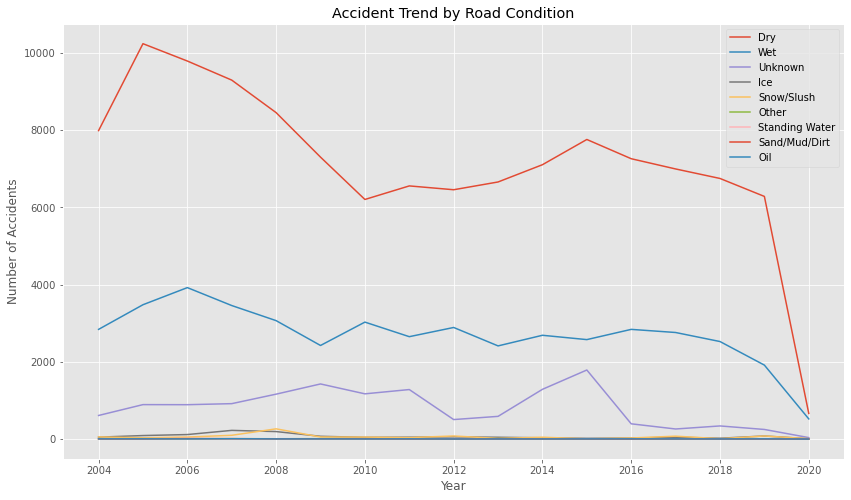

In [41]:
#PREPARE dataframe to plot

#Calculate totals for year-weather-combo
roadcond_df = work_df.groupby(['Year','ROADCOND']).size().reset_index(name='Count')

#add the road condition options as columns and move the groupby totals to corresponding column
roadcond_df['Dry'] = np.where(roadcond_df['ROADCOND'].str.contains('Dry'),roadcond_df['Count'], 0)
roadcond_df['Wet'] = np.where(roadcond_df['ROADCOND'].str.contains('Wet'),roadcond_df['Count'], 0)
roadcond_df['Unknown'] = np.where(roadcond_df['ROADCOND'].str.contains('Unknown'),roadcond_df['Count'], 0)
roadcond_df['Ice'] = np.where(roadcond_df['ROADCOND'].str.contains('Ice'),roadcond_df['Count'], 0)
roadcond_df['Snow/Slush'] = np.where(roadcond_df['ROADCOND'].str.contains('Slush'),roadcond_df['Count'], 0)
roadcond_df['Other'] = np.where(roadcond_df['ROADCOND'].str.contains('Other'),roadcond_df['Count'], 0)
roadcond_df['Standing Water'] = np.where(roadcond_df['ROADCOND'].str.contains('Water'),roadcond_df['Count'], 0)
roadcond_df['Sand/Mud/Dirt'] = np.where(roadcond_df['ROADCOND'].str.contains('Mud'),roadcond_df['Count'], 0)
roadcond_df['Oil'] = np.where(roadcond_df['ROADCOND'].str.contains('Oil'),roadcond_df['Count'], 0)

#drop unwanted columns
roadcond_df.drop(['ROADCOND','Count'],axis=1,inplace=True)

#MERGE rows so that there is one per year
line_roadcond_df = roadcond_df.groupby(['Year']).sum()[['Dry','Wet','Unknown','Ice','Snow/Slush','Other','Standing Water','Sand/Mud/Dirt','Oil']]

#PLOT WEATHER
line_roadcond_df.index = line_roadcond_df.index.map(int)
line_roadcond_df.plot(kind='line', figsize=(14, 8))
plt.title('Accident Trend by Road Condition')
plt.ylabel('Number of Accidents')
plt.xlabel('Year')
plt.show()


## Plot Light Condition Trend

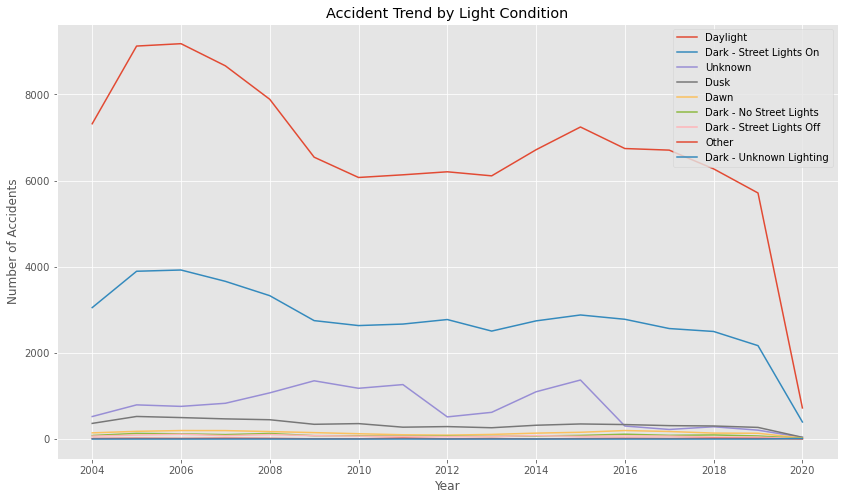

In [42]:
#PREPARE dataframe to plot

#Calculate totals for year-weather-combo
lightcond_df = work_df.groupby(['Year','LIGHTCOND']).size().reset_index(name='Count')

#add the road condition options as columns and move the groupby totals to corresponding column
lightcond_df['Daylight'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Daylight'),lightcond_df['Count'], 0)
lightcond_df['Dark - Street Lights On'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Dark - Street Lights On'),lightcond_df['Count'], 0)
lightcond_df['Unknown'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Unknown'),lightcond_df['Count'], 0)
lightcond_df['Dusk'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Dusk'),lightcond_df['Count'], 0)
lightcond_df['Dawn'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Dawn'),lightcond_df['Count'], 0)
lightcond_df['Dark - No Street Lights'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Dark - No Street Lights'),lightcond_df['Count'], 0)
lightcond_df['Dark - Street Lights Off'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Dark - Street Lights Off'),lightcond_df['Count'], 0)
lightcond_df['Other'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Other'),lightcond_df['Count'], 0)
lightcond_df['Dark - Unknown Lighting'] = np.where(lightcond_df['LIGHTCOND'].str.contains('Dark - Unknown Lighting'),lightcond_df['Count'], 0)

#drop unwanted columns
lightcond_df.drop(['LIGHTCOND','Count'],axis=1,inplace=True)

#MERGE rows so that there is one per year
line_lightcond_df = lightcond_df.groupby(['Year']).sum()[['Daylight','Dark - Street Lights On','Unknown','Dusk',
                                                          'Dawn','Dark - No Street Lights','Dark - Street Lights Off','Other','Dark - Unknown Lighting']]

#PLOT WEATHER
line_lightcond_df.index = line_lightcond_df.index.map(int)
line_lightcond_df.plot(kind='line', figsize=(14, 8))
plt.title('Accident Trend by Light Condition')
plt.ylabel('Number of Accidents')
plt.xlabel('Year')
plt.show()

## Plot Collision Type trend

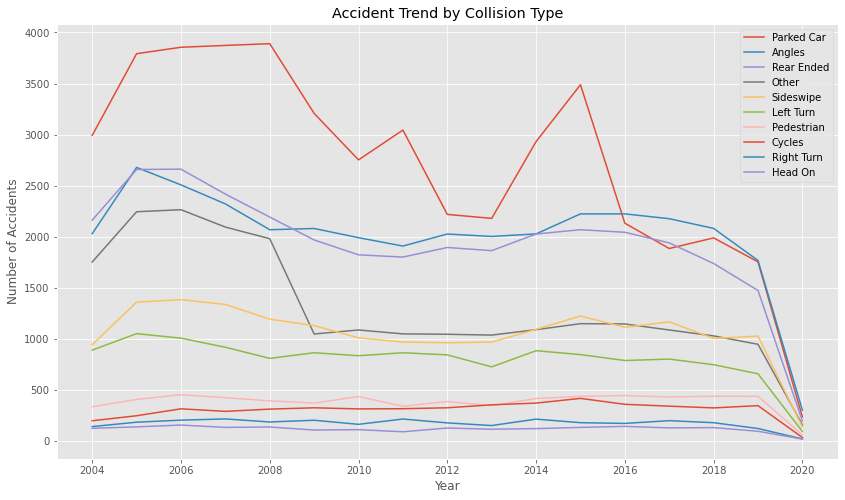

In [46]:
#PREPARE dataframe to plot

#Calculate totals for year-weather-combo
collisionType_df = work_df.groupby(['Year','COLLISIONTYPE']).size().reset_index(name='Count')

#add the collision type options as columns and move the groupby totals to corresponding column
collisionType_df['Parked Car'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Parked Car'),collisionType_df['Count'], 0)
collisionType_df['Angles'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Angles'),collisionType_df['Count'], 0)
collisionType_df['Rear Ended'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Rear Ended'),collisionType_df['Count'], 0)
collisionType_df['Other'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Other'),collisionType_df['Count'], 0)
collisionType_df['Sideswipe'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Sideswipe'),collisionType_df['Count'], 0)
collisionType_df['Left Turn'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Left Turn'),collisionType_df['Count'], 0)
collisionType_df['Pedestrian'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Pedestrian'),collisionType_df['Count'], 0)
collisionType_df['Cycles'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Cycles'),collisionType_df['Count'], 0)
collisionType_df['Right Turn'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Right Turn'),collisionType_df['Count'], 0)
collisionType_df['Head On'] = np.where(collisionType_df['COLLISIONTYPE'].str.contains('Head On'),collisionType_df['Count'], 0)


#drop unwanted columns
collisionType_df.drop(['COLLISIONTYPE','Count'],axis=1,inplace=True)

#MERGE rows so that there is one per year
line_collisionType_df = collisionType_df.groupby(['Year']).sum()[['Parked Car','Angles','Rear Ended','Other','Sideswipe',
                                                                  'Left Turn','Pedestrian','Cycles','Right Turn','Head On']]

#PLOT WEATHER
line_collisionType_df.index = line_collisionType_df.index.map(int)
line_collisionType_df.plot(kind='line', figsize=(14, 8))
plt.title('Accident Trend by Collision Type')
plt.ylabel('Number of Accidents')
plt.xlabel('Year')
plt.show()

## Plot Accident Year-Hour trend

In [47]:
print(feature_df.shape)
feature_df.head()

(183950, 10)


,Year,SEVERITYCODE,X,Y,VEHCOUNT,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,INCDTTM
0,2013,2,-122.323148,47.703140,2,Angles,Overcast,Wet,Daylight,2013-03-27 14:54:00
1,2006,1,-122.347294,47.647172,2,Sideswipe,Raining,Wet,Dark - Street Lights On,2006-12-20 18:55:00
2,2004,1,-122.334540,47.607871,3,Parked Car,Overcast,Dry,Daylight,2004-11-18 10:20:00
3,2013,1,-122.334803,47.604803,3,Other,Clear,Dry,Daylight,2013-03-29 09:26:00
4,2004,2,-122.306426,47.545739,2,Angles,Raining,Wet,Daylight,2004-01-28 08:04:00


In [48]:
yr_hr_df = feature_df[['INCDTTM']]
yr_hr_df.insert(0, 'Year', yr_hr_df['INCDTTM'].dt.year)
yr_hr_df.insert(0, 'Hour', yr_hr_df['INCDTTM'].dt.hour)
yr_hr_df.drop(['INCDTTM'],axis=1,inplace=True)
yr_hr_df.head()

C:\Users\kpurs\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Hour,Year
0,14,2013
1,18,2006
2,10,2004
3,9,2013
4,8,2004


In [49]:
yr_hr_df.sort_values(by=['Hour','Year'], ascending=True, inplace=True)

plot_df = yr_hr_df.groupby(['Year','Hour']).size().reset_index(name='Count')

print(yr_hr_df.shape)
plot_df.head()

(183950, 2)


<ipython-input-49-e2092ee9877d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yr_hr_df.sort_values(by=['Hour','Year'], ascending=True, inplace=True)


,Year,Hour,Count
0,2004,0,3753
1,2004,1,182
2,2004,2,220
3,2004,3,94
4,2004,4,83


In [50]:
plot_df.dtypes

Year     int64
Hour     int64
Count    int64
dtype: object

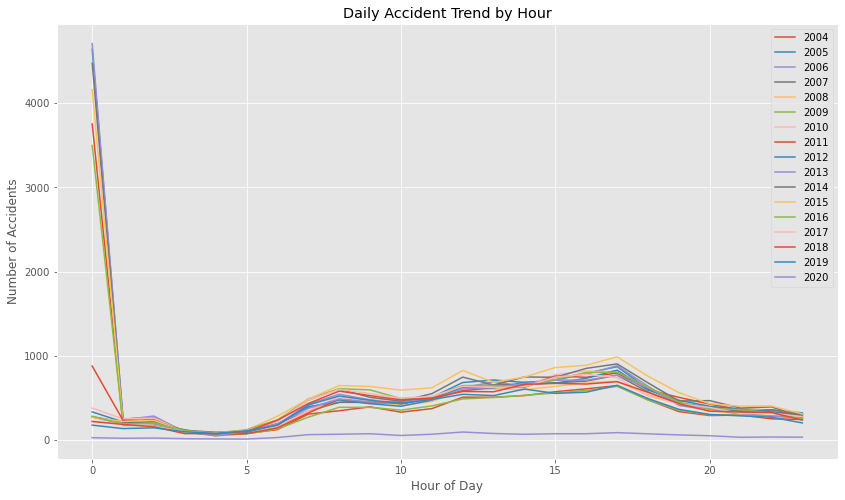

In [51]:
plot_df['2004'] = np.where(plot_df['Year']==2004,plot_df['Count'], 0)
plot_df['2005'] = np.where(plot_df['Year']==2005,plot_df['Count'], 0)
plot_df['2006'] = np.where(plot_df['Year']==2006,plot_df['Count'], 0)
plot_df['2007'] = np.where(plot_df['Year']==2007,plot_df['Count'], 0)
plot_df['2008'] = np.where(plot_df['Year']==2008,plot_df['Count'], 0)
plot_df['2009'] = np.where(plot_df['Year']==2009,plot_df['Count'], 0)
plot_df['2010'] = np.where(plot_df['Year']==2010,plot_df['Count'], 0)
plot_df['2011'] = np.where(plot_df['Year']==2011,plot_df['Count'], 0)
plot_df['2012'] = np.where(plot_df['Year']==2012,plot_df['Count'], 0)
plot_df['2013'] = np.where(plot_df['Year']==2013,plot_df['Count'], 0)
plot_df['2014'] = np.where(plot_df['Year']==2014,plot_df['Count'], 0)
plot_df['2015'] = np.where(plot_df['Year']==2015,plot_df['Count'], 0)
plot_df['2016'] = np.where(plot_df['Year']==2016,plot_df['Count'], 0)
plot_df['2017'] = np.where(plot_df['Year']==2017,plot_df['Count'], 0)
plot_df['2018'] = np.where(plot_df['Year']==2018,plot_df['Count'], 0)
plot_df['2019'] = np.where(plot_df['Year']==2019,plot_df['Count'], 0)
plot_df['2020'] = np.where(plot_df['Year']==2020,plot_df['Count'], 0)

#drop unwanted columns
plot_df.drop(['Year','Count'],axis=1,inplace=True)

#MERGE rows so that there is one per year
line_hr_df = plot_df.groupby(['Hour']).sum()[['2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']]

#PLOT WEATHER
line_hr_df.index = line_hr_df.index.map(int)
line_hr_df.plot(kind='line', figsize=(14, 8))
plt.title('Daily Accident Trend by Hour')
plt.ylabel('Number of Accidents')
plt.xlabel('Hour of Day')
plt.show()